# Training Mask R-CNN Model

In [1]:
import torch 
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from custom_dataset_loader import CustomCocoManualDataset
import time
from torch.cuda.amp import GradScaler, autocast  # For mixed precision training (optional)

### Initializing the COCO Dataset 

In [2]:
#Initializing Datasets
train_dataset = CustomCocoManualDataset(
    root='dataset/prod/yolo_dataset/train/images',  # Path to images
    annFile='dataset/prod/yolo_dataset/train/annotations/coco_annotation.json',  # Path to COCO annotations
    transforms=T.ToTensor()  # Apply ToTensor transform	
)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!


In [3]:
valid_dataset = CustomCocoManualDataset(
    root='dataset/prod/yolo_dataset/valid/images',  # Path to images
    annFile='dataset/prod/yolo_dataset/valid/annotations/coco_annotation.json',  # Path to COCO annotations
    transforms=T.ToTensor()  # Apply ToTensor transform
)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


### Initializing Data Loader

In [4]:
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    collate_fn= lambda batch: tuple(zip(*batch))
)

In [5]:
validation_loader = DataLoader(
    valid_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    collate_fn= lambda batch: tuple(zip(*batch))
)

### Initializing Model, Optimizer, Scheduler and Gradient Scaler

In [6]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

c:\Users\devin\.conda\envs\py3-8-11\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\devin\.conda\envs\py3-8-11\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
num_classes = 7 
in_features = model.roi_heads.box_predictor.cls_score.in_features

In [8]:
#box predictor
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256


In [9]:
# Passing the model to the device

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

### Optimizer Configuration

In [10]:
#configuring adam optimizer for the model 

lr = 0.001
weight_decay = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
scaler = GradScaler()

### Training Loop (Without Cross Validation)

In [16]:
num_epochs = 15
train_losses = []
valid_losses = []

### Training Loop (With Cross Validation)

In [11]:
import torch

In [ ]:
torch.backends.cudnn.benchmark = True  # Use benchmark mode to speed up training

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start_time = time.time()

    # Training loop
    for i, (images, targets) in enumerate(train_loader):
        
        # Loading images and forward pass 
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        
        # Forward propagation
        with autocast():
            # Loss calculation
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
        # Backward propagation
        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()
        
        epoch_loss += losses.item()
        
        # Log progress after every 10 batches 
        if (i + 1) % 10 == 0:
            print(f'Epoch: [{epoch+1}/{num_epochs}], Batch: [{i}/{len(train_loader)}], Loss: {losses.item():4f}') 
            
    # Average training loss for the epoch 
    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)
    
    print(f'Epoch: [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {time.time() - start_time:.2f} s')

    # Validation step
    model.eval()  # Keep the model in train mode to compute the validation loss properly
    validation_loss = 0.0
    
    with torch.no_grad():  # Disable gradient calculations
        for i, (images, targets) in enumerate(validation_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            with autocast():
                # Calculate validation loss during evaluation in training mode
                val_loss_dict = model(images, targets)
                val_losses = sum(loss for loss in val_loss_dict.values())
                
            validation_loss += val_losses.item()
    
    # Average validation loss for the epoch
    validation_loss /= len(validation_loader)
    valid_losses.append(validation_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Loss: {validation_loss:.4f}')
    
    # Update the learning rate scheduler
    lr_scheduler.step()
    
    # Save the model checkpoint for this epoch 
    checkpoint_path = f'checkpoints_cnn/mask_rcnn_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    print(f'Model saved at {checkpoint_path}')

print('Training with Validation Complete')


### ONLY USING TRAINING LOSS

In [12]:
num_epochs = 20

# Initialize variables to store training and validation metrics
train_losses = {
    "classification-loss": [],
    "regression-loss": [],
    "mask-loss": [],
    "rpn-classification-loss": [],
    "rpn-regression-loss": [],
    "total-loss": [],
    "total-avg": []
}

In [13]:
def calc_loss(loss_dict):
    classification_loss = loss_dict['loss_classifier']
    regression_loss = loss_dict['loss_box_reg']
    mask_loss = loss_dict['loss_mask']
    rpn_class_loss = loss_dict['loss_objectness']
    rpn_reg_loss = loss_dict['loss_rpn_box_reg']
    total_loss = sum(loss for loss in loss_dict.values())
    
    return classification_loss, regression_loss, mask_loss, rpn_class_loss, rpn_reg_loss,total_loss

In [14]:
import torch.backends as amp
amp.cudnn.benchmark = True

for epoch in range(num_epochs):
    model.train()
    epoch_class_loss = 0.0
    epoch_reg_loss = 0.0
    epoch_mask_loss = 0.0
    epoch_rpn_class_loss = 0.0
    epoch_rpn_reg_loss = 0.0
    epoch_total_loss = 0.0
    
    start_time = time.time()
    
    #training loop
    for i, (images, targets) in enumerate(train_loader):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        
        #forward propagation
        with autocast():
            
            #loss calculation
            loss_dict = model(images, targets)
            classification_loss, regression_loss, mask_loss, rpn_class_loss, rpn_reg_loss, total_loss = calc_loss(loss_dict)
        
        #backward propagation
        scaler.scale(total_loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        #summing losses for batch-level
        num_batches = len(train_loader)
        epoch_class_loss += classification_loss.item()
        epoch_reg_loss += regression_loss.item()
        epoch_rpn_class_loss += rpn_class_loss.item()
        epoch_rpn_reg_loss += rpn_reg_loss.item()
        epoch_mask_loss += mask_loss.item()
        epoch_total_loss += total_loss.item()
        
        #log the progress for every 10 batches
        if (i + 1) % 10 == 0 :
            print(f'Epoch: [{epoch+1}/{num_epochs}], Loss: {epoch_total_loss / num_batches:.4f}, Time: {time.time() - start_time:.2f} s')
        
    # Average training loss for the epoch
    avg_classification_loss = epoch_class_loss / num_batches
    avg_regression_loss = epoch_reg_loss / num_batches
    avg_mask_loss = epoch_mask_loss / num_batches
    avg_rpn_class_loss = epoch_rpn_class_loss / num_batches
    avg_rpn_reg_loss = epoch_rpn_reg_loss / num_batches
    avg_total_loss = epoch_total_loss / num_batches
    
    #Average training loss for epoch 
    train_losses["classification-loss"].append(epoch_class_loss / num_batches)
    train_losses["regression-loss"].append(epoch_reg_loss / num_batches)
    train_losses["mask-loss"].append(epoch_mask_loss / num_batches)
    train_losses["rpn-classification-loss"].append(epoch_rpn_class_loss / num_batches)
    train_losses["rpn-regression-loss"].append(epoch_rpn_reg_loss / num_batches)
    train_losses["total-loss"].append(epoch_total_loss / num_batches)
    train_losses["total-avg"].append(epoch_total_loss / num_batches)
    
        # Display detailed losses after each epoch
    print(f'\nEpoch [{epoch+1}/{num_epochs}] Training Losses:')
    print(f'  Classification Loss: {avg_classification_loss:.4f}')
    print(f'  Regression Loss:     {avg_regression_loss:.4f}')
    print(f'  Mask Loss:           {avg_mask_loss:.4f}')
    print(f'  RPN Classification Loss: {avg_rpn_class_loss:.4f}')
    print(f'  RPN Regression Loss: {avg_rpn_reg_loss:.4f}')
    print(f'  Total Loss:          {avg_total_loss:.4f}')
    print(f'  Time:                {time.time() - start_time:.2f} s\n')
    
    #save the model checkpoint for this epoch 
    checkpoint_path = f'checkpoints/prod/final/checkpoint_epoch_{epoch + 1}.pth'
    torch.save(model.state_dict(),checkpoint_path)
    
    print(f'Checkpoint {epoch + 1} saved!\n')

Epoch: [1/20], Loss: 0.0654, Time: 11.52 s
Epoch: [1/20], Loss: 0.0972, Time: 16.15 s
Epoch: [1/20], Loss: 0.1048, Time: 20.14 s
Epoch: [1/20], Loss: 0.1117, Time: 24.57 s
Epoch: [1/20], Loss: 0.1180, Time: 28.91 s
Epoch: [1/20], Loss: 0.1259, Time: 34.66 s
Epoch: [1/20], Loss: 0.1326, Time: 39.56 s
Epoch: [1/20], Loss: 0.1397, Time: 45.16 s
Epoch: [1/20], Loss: 0.1478, Time: 51.89 s
Epoch: [1/20], Loss: 0.1559, Time: 58.11 s
Epoch: [1/20], Loss: 0.1627, Time: 63.62 s
Epoch: [1/20], Loss: 0.1701, Time: 69.46 s
Epoch: [1/20], Loss: 0.1784, Time: 75.14 s
Epoch: [1/20], Loss: 0.1861, Time: 82.06 s
Epoch: [1/20], Loss: 0.1924, Time: 87.08 s
Epoch: [1/20], Loss: 0.1989, Time: 92.49 s
Epoch: [1/20], Loss: 0.2056, Time: 97.44 s
Epoch: [1/20], Loss: 0.2114, Time: 102.18 s
Epoch: [1/20], Loss: 0.2189, Time: 107.93 s
Epoch: [1/20], Loss: 0.2267, Time: 114.46 s
Epoch: [1/20], Loss: 0.2340, Time: 119.69 s
Epoch: [1/20], Loss: 0.2407, Time: 123.84 s
Epoch: [1/20], Loss: 0.2463, Time: 128.02 s
Epoch

### Loss Chart Visualization

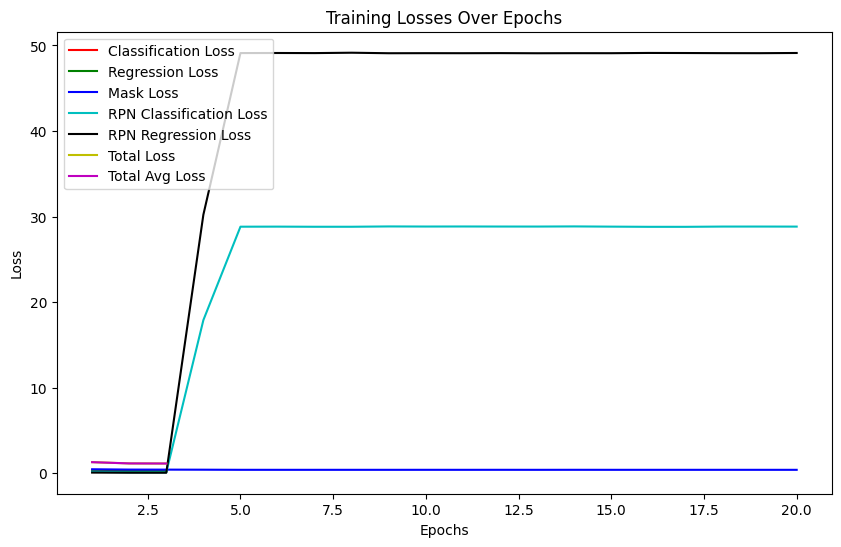

In [15]:
import matplotlib.pyplot as plt

# Generate x-axis values (epochs)
epochs = range(1, len(train_losses['classification-loss']) + 1)

# Plot each loss type
plt.figure(figsize=(10, 6))

plt.plot(epochs, train_losses['classification-loss'], 'r-', label='Classification Loss')
plt.plot(epochs, train_losses['regression-loss'], 'g-', label='Regression Loss')
plt.plot(epochs, train_losses['mask-loss'], 'b-', label='Mask Loss')
plt.plot(epochs, train_losses['rpn-classification-loss'], 'c-', label='RPN Classification Loss')
plt.plot(epochs, train_losses['rpn-regression-loss'], 'k-', label='RPN Regression Loss')
plt.plot(epochs, train_losses['total-avg'], 'y-', label='Total Loss')
plt.plot(epochs, train_losses['total-avg'], 'm-', label='Total Avg Loss')

# Adding labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses Over Epochs')
plt.legend()

# Show the plot
plt.show()

### Saving Current Session Training Data in JSON

In [14]:
import json
import os

# Check if the log file exists
log_file_path = 'training_logs/training_data.json'

# Load the existing log data if the file exists
if os.path.exists(log_file_path):
    with open(log_file_path, 'r') as log_file:
        try:
            log_data = json.load(log_file)
        except json.JSONDecodeError:
            # If the file exists but is empty or corrupt, initialize the structure
            log_data = {}
else:
    # If the file doesn't exist, create a new structure
    log_data = {}

# Ensure that 'records' key exists in the log_data
if 'records' not in log_data:
    log_data['records'] = []

# Prepare new data to append
new_data = {
    'num_epochs': num_epochs,
    'train_losses': train_losses,
    'valid_losses': valid_losses
}

# Append the new record to the existing data
log_data['records'].append(new_data)

# Save the updated log data
with open(log_file_path, 'w') as log_file:
    json.dump(log_data, log_file, indent=4)

print(f"Training log appended to '{log_file_path}'")


Training log appended to 'training_logs/training_data.json'


### Plotting Training and Validation Loss Graphs based on each epoch

In [15]:
### Fetching Losses from JSON and Visualizing
import json
import matplotlib.pyplot as plt

def plot_loss_from_json(json_file_path):
    # Read the JSON file to get the latest data
    with open(json_file_path, 'r') as f:
        log_data = json.load(f)

    # Fetch the latest record from the JSON
    if 'records' in log_data and len(log_data['records']) > 0:
        latest_record = log_data['records'][-1]  # Get the last record (latest)
    else:
        print("Error: No records found in the JSON file.")
        return

    # Extracting the data from the latest record
    num_epochs = latest_record['num_epochs']
    train_losses = latest_record['train_losses']
    valid_losses = latest_record['valid_losses']

    # Check if the data is valid
    if len(train_losses) != num_epochs or len(valid_losses) != num_epochs:
        print("Error: Mismatch between the number of epochs and the length of train_losses or valid_losses.")
        return

    # Plotting
    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(epochs, train_losses, 'r-', label='Training Loss')

    # Plot validation loss
    plt.plot(epochs, valid_losses, 'b-', label='Validation Loss')

    # Labeling
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()



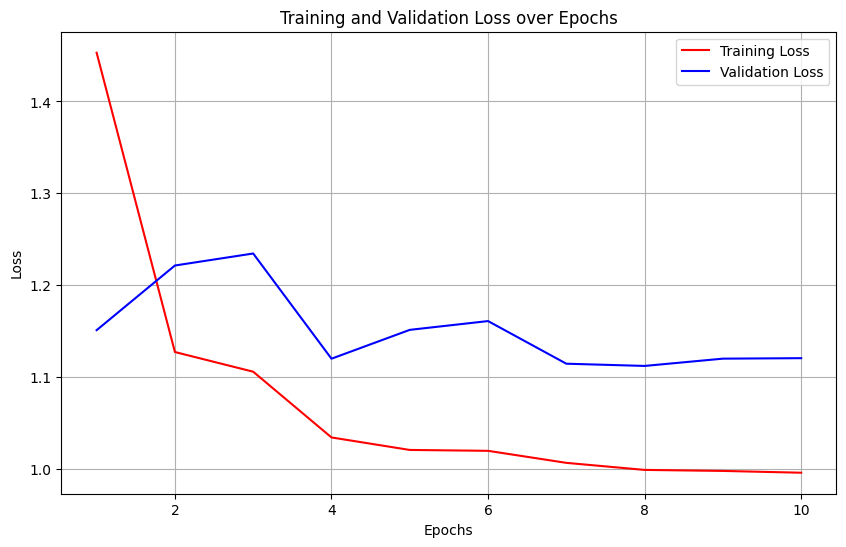

In [16]:
# Example usage: Call the function with the path to your JSON log file
plot_loss_from_json('training_logs/training_data.json')

### IOU Calculation

The IoU measures the overlap between the predicted bounding box and the ground truth bounding box. It is given by:

$$
\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
$$

Where:
- Area of Overlap is the intersection area between the predicted bounding box and the ground truth bounding box.
- Area of Union is the combined area of the predicted and ground truth boxes.

---

### Precision, Recall and F1 Calculation

#### Precision

Precision measures how many of the predicted bounding boxes are actually correct. It is given by:

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

Where:
- \( TP \) are True Positives (correctly predicted objects).
- \( FP \) are False Positives (incorrectly predicted objects).

---

#### Recall

Recall measures how many of the actual objects were correctly predicted. It is given by:

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

Where:
- \( TP \) are True Positives (correctly predicted objects).
- \( FN \) are False Negatives (objects that the model failed to predict).

---

#### F1 Score

The F1 score is the harmonic mean of precision and recall. It is given by:

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

###  Calculation of IOU for better Cross Validation